# Data Scraping and The Movie Database Api

## Data Scraping From Box Office Mojo

So I wanted to collect data from the website box office mojo to make a dataset of the top grossing movies all time. 

The page that has this information can be found 
here:https://www.boxofficemojo.com/chart/ww_top_lifetime_gross/    

To get this data we are gonna have python send a request for the information of that page iterate through it and look for the markers unique to the data that we wanna collect. We need python to do this for every row and every page.

I wanted to make the same dataset as JVasquez5's which can be found:https://github.com/JVasquez5/dsc-mod-1-project-v2-1-nyc01-dtsc-ft-051120/blob/master/Data_Web_Scraping_%26_API.ipynb. From him I used the tags to find the data found in the function BOMscrap later and merging both data sets I implemented them differently but I learned from reading his project.


In [1]:
#First import the modules that we are gonna be using below
import requests #To make http requests
from bs4 import BeautifulSoup as bs #To make soup and be able to extract data from our requests.
import pandas as pd# To store look at and manipulate our data
import json# To properly read the results of api requests
pd.set_option('display.float_format', lambda x: '%.1f' % x)

   When you go to the next page on the website I noticed the end of the link changes to
'?offset=200'. I figured that that was the amount of rows to skip since it increased by 200 per page with 800 being the last page. So instead of making something that runs 5 times we can just use a loop.

In [2]:
#added a variable for the link so that we could use the .format() methood later
link = 'https://www.boxofficemojo.com/chart/ww_top_lifetime_gross/{}'
#make a variable x that is the value that we will pass into the offset attribute
x = 0
#make a list of the 5 pages we will use.
linklist = []

while x < 1000:#                            While we arent x doesnt equal 1000 we havent got all
    command= '?offset={}'.format(x)#   the pages so we set the offset to our next page 200 rows
    y = link.format(command)#.         and clone the link thats empty name it y and add our offset             
    linklist.append(y)#                we then add that list to the end of the dictionary and
    x+=200#                            and finally add 200 to x so we get the next 200 
#                                      until we finish.
print(linklist)


['https://www.boxofficemojo.com/chart/ww_top_lifetime_gross/?offset=0', 'https://www.boxofficemojo.com/chart/ww_top_lifetime_gross/?offset=200', 'https://www.boxofficemojo.com/chart/ww_top_lifetime_gross/?offset=400', 'https://www.boxofficemojo.com/chart/ww_top_lifetime_gross/?offset=600', 'https://www.boxofficemojo.com/chart/ww_top_lifetime_gross/?offset=800']


Next we are gonna make a function that will go through the data that we will get from Box Office Movies after it goes through beautiful soup and have it give us the rows of data.

In [3]:
# next we are gonna make a function that will take in the result of the request and give
# you the rows of data
def BOMscrap(entry):
    movie_list = []#final list
    for record in entry.findAll("tr"): #             for every record that has the tag 'tr' in
        row = [x.text for x in record.findAll("td")]#our entry make a row of all the info in that 
        for a in record.findAll('a', href=True):#   record using the 'td' tag. if a link in the 
            if a['href'].startswith('/title/'):#    record starts with title remove the link portion
                row.append(a['href'][7:16])#        and add it to our current row. finally if the row
        if len(row)>0:#                             isnt empty add it to our list of rows.
            movie_list.append(row)
    return movie_list

So now we have a function that can take in processed data from a link and we have a list of links. The next thing we have to do is put our data through beautiful soup so that we can use our function to crunch it down to only the information that we want then add it to a list fulllist which will contain all 5 pages worth of data.

In [4]:
fulllist = []#                                for every link in our list linklist get the html
for link in linklist:#                     data for that link(page info) and turn it into a 
    r = requests.get(link)#                beautiful soup object and make a temporary
    soup = bs(r.content,'html.parser')#    variable 'page' which is equal to that pages 200
    page = BOMscrap(soup)#                 rows of data and add the rows to our list fulllist.
    fulllist += page


So now we sould have a thousand rows of data, we are gonna verify this and make a list of the names of the columns that we have extracted.

In [5]:
print(len(fulllist))#make sure are assumtion is right
header = ['Rank', 'Title', 'Worldwide_Lifetime_Gross', #making the columns
          'Domestic_Lifetime_Gross', 'Domestic_Percentage', 
          'Foreign_Lifetime_Gross', 'Foreign_Lifetime_Percentage', 
          'Year', 'imdb_id']

1000


Now that we have made a header list we can use the modules pandas(pd) to make a dataframe(completed_df) that will hold our data.

In [6]:
completed_df = pd.DataFrame(fulllist, columns = header)# make a dataframe from the listoflist fulllist
completed_df

,Rank,Title,Worldwide_Lifetime_Gross,Domestic_Lifetime_Gross,Domestic_Percentage,Foreign_Lifetime_Gross,Foreign_Lifetime_Percentage,Year,imdb_id
0,1,Avengers: Endgame,"$2,797,800,564","$858,373,000",30.7%,"$1,939,427,564",69.3%,2019,tt4154796
1,2,Avatar,"$2,790,439,000","$760,507,625",27.2%,"$2,029,931,375",72.8%,2009,tt0499549
2,3,Titanic,"$2,195,169,869","$659,363,944",30%,"$1,535,805,925",70%,1997,tt0120338
3,4,Star Wars: Episode VII - The Force Awakens,"$2,068,224,036","$936,662,225",45.3%,"$1,131,561,811",54.7%,2015,tt2488496
4,5,Avengers: Infinity War,"$2,048,359,754","$678,815,482",33.1%,"$1,369,544,272",66.9%,2018,tt4154756
...,...,...,...,...,...,...,...,...,...
995,"1,011",Unstoppable,"$167,805,466","$81,562,942",48.6%,"$86,242,524",51.4%,2010,tt0477080
996,"1,012",Three Men and a Baby,"$167,780,960","$167,780,960",100%,$0,-,1987,tt0094137
997,"1,013",Magic Mike,"$167,739,368","$113,721,571",67.8%,"$54,017,797",32.2%,2012,tt1915581
998,"1,014",Alexander,"$167,298,192","$34,297,191",20.5%,"$133,001,001",79.5%,2004,tt0346491


Ok so we have 1000 movies and some information about how much money they have made, when they were made, etc. But thats not enough info for every row to do the analysis that we wanted to do so we are gonna use the series or column 'imdb_id' with a movie database api to contact the site tmdb and request some more info

In [7]:
movieids = completed_df.imdb_id#Store the series for ease
tmdb_list = []
for id in movieids:#Check every movie and get read the json turn it to a dict and add it to our new data list
    response = requests.get("https://api.themoviedb.org/3/movie/" + id + "?api_key=" + "e69606ff3cabd3ebbba0d97046bc81ba" + "&language=en-US")
    data = response.json()
    tmdb_list.append(data)


Now we have a list of dictionaries that we can also convert to a dataframe.

In [8]:
tmdbdf=pd.DataFrame(tmdb_list)
tmdbdf

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,success,status_code,status_message
0,False,/orjiB3oUIsyz60hoEqkiGpy5CeO.jpg,"{'id': 86311, 'name': 'The Avengers Collection...",356000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 878, ...",https://www.marvel.com/movies/avengers-endgame,299534.0,tt4154796,en,Avengers: Endgame,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Part of the journey is the end.,Avengers: Endgame,False,8.3,14637.0,NaN,nan,NaN
1,False,/bIL7ENqh1egWTxN41sM2W42JqPc.jpg,"{'id': 87096, 'name': 'Avatar Collection', 'po...",237000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,19995.0,tt0499549,en,Avatar,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Enter the World of Pandora.,Avatar,False,7.4,21862.0,NaN,nan,NaN
2,False,/6VmFqApQRyZZzmiGOQq2C92jyvH.jpg,None,200000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",,597.0,tt0120338,en,Titanic,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Nothing on Earth could come between them.,Titanic,False,7.9,17526.0,NaN,nan,NaN
3,False,/k6EOrckWFuz7I4z4wiRwz8zsj4H.jpg,"{'id': 10, 'name': 'Star Wars Collection', 'po...",245000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.starwars.com/films/star-wars-episod...,140607.0,tt2488496,en,Star Wars: The Force Awakens,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Every generation has a story.,Star Wars: The Force Awakens,False,7.4,14816.0,NaN,nan,NaN
4,False,/bOGkgRGdhrBYJSLpXaxhXVstddV.jpg,"{'id': 86311, 'name': 'The Avengers Collection...",300000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",https://www.marvel.com/movies/avengers-infinit...,299536.0,tt4154756,en,Avengers: Infinity War,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,An entire universe. Once and for all.,Avengers: Infinity War,False,8.3,19349.0,NaN,nan,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,False,/3uzw2L5iwg1Hn3y6u80sX4DLWVe.jpg,None,100000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",,44048.0,tt0477080,en,Unstoppable,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"1,000,000 Tons. 100,000 Lives. 100 Minutes.",Unstoppable,False,6.4,2316.0,NaN,nan,NaN
996,False,/tAP8xGnUtOSlYuxtGhcFnHoARRs.jpg,"{'id': 107688, 'name': '3 Men Collection', 'po...",11000000.0,"[{'id': 10751, 'name': 'Family'}, {'id': 35, '...",,12154.0,tt0094137,en,3 Men and a Baby,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,They changed her diapers. She changed their li...,3 Men and a Baby,False,6.1,611.0,NaN,nan,NaN
997,False,/pwaETwSrgWeDutTeianu99LqUKk.jpg,"{'id': 328247, 'name': 'Magic Mike Collection'...",7000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",http://magicmikemovie.warnerbros.com,77930.0,tt1915581,en,Magic Mike,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Work all day. Work it all night.,Magic Mike,False,6.1,2197.0,NaN,nan,NaN
998,False,/sqY4MVhtCCwQsUaiO9ge3HLSfYy.jpg,None,155000000.0,"[{'id': 10752, 'name': 'War'}, {'id': 36, 'nam...",,1966.0,tt0346491,en,Alexander,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The greatest legend of all was real,Alexander,False,5.9,2268.0,NaN,nan,NaN


Now though we have alot more columns for each movie but most of them we don't need so we are just gonna go ahead and drop those columns

In [9]:
tmbddf = tmdbdf.drop(['backdrop_path', 'homepage', 
                             'id', 'original_title', 'overview', 
                             'poster_path', 'revenue', 'status',
                             'spoken_languages', 'tagline','title',
                             'status_code',
                             'status_message', 'video'], axis = 1)#axis specifies column
tmbddf

,adult,belongs_to_collection,budget,genres,imdb_id,original_language,popularity,production_companies,production_countries,release_date,runtime,vote_average,vote_count,success
0,False,"{'id': 86311, 'name': 'The Avengers Collection...",356000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 878, ...",tt4154796,en,36.4,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ...","[{'iso_3166_1': 'US', 'name': 'United States o...",2019-04-24,181.0,8.3,14637.0,NaN
1,False,"{'id': 87096, 'name': 'Avatar Collection', 'po...",237000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",tt0499549,en,35.1,"[{'id': 444, 'logo_path': '/42UPdZl6B2cFXgNUAS...","[{'iso_3166_1': 'US', 'name': 'United States o...",2009-12-10,162.0,7.4,21862.0,NaN
2,False,None,200000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",tt0120338,en,28.2,"[{'id': 4, 'logo_path': '/fycMZt242LVjagMByZOL...","[{'iso_3166_1': 'US', 'name': 'United States o...",1997-11-18,194.0,7.9,17526.0,NaN
3,False,"{'id': 10, 'name': 'Star Wars Collection', 'po...",245000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",tt2488496,en,29.2,"[{'id': 1634, 'logo_path': None, 'name': 'True...","[{'iso_3166_1': 'US', 'name': 'United States o...",2015-12-15,136.0,7.4,14816.0,NaN
4,False,"{'id': 86311, 'name': 'The Avengers Collection...",300000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",tt4154756,en,77.3,"[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ...","[{'iso_3166_1': 'US', 'name': 'United States o...",2018-04-25,149.0,8.3,19349.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,False,None,100000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",tt0477080,en,11.6,"[{'id': 19776, 'logo_path': None, 'name': 'Pro...","[{'iso_3166_1': 'US', 'name': 'United States o...",2010-11-04,98.0,6.4,2316.0,NaN
996,False,"{'id': 107688, 'name': '3 Men Collection', 'po...",11000000.0,"[{'id': 10751, 'name': 'Family'}, {'id': 35, '...",tt0094137,en,12.3,"[{'id': 9195, 'logo_path': '/ou5BUbtulr6tIt699...","[{'iso_3166_1': 'US', 'name': 'United States o...",1987-11-27,102.0,6.1,611.0,NaN
997,False,"{'id': 328247, 'name': 'Magic Mike Collection'...",7000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",tt1915581,en,10.2,"[{'id': 34981, 'logo_path': None, 'name': 'Iro...","[{'iso_3166_1': 'US', 'name': 'United States o...",2012-06-28,110.0,6.1,2197.0,NaN
998,False,None,155000000.0,"[{'id': 10752, 'name': 'War'}, {'id': 36, 'nam...",tt0346491,en,14.5,"[{'id': 174, 'logo_path': '/IuAlhI9eVC9Z8UQWOI...","[{'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...",2004-11-21,175.0,5.9,2268.0,NaN


We are gonna want to clean our data because alot of it is unusable in this state and also we want one big data frame not two smaller ones especially since they have data for the same movies.

In [10]:
tmdbdf.dropna(axis=0, how="all", inplace=True)#Drop anything that is null
merged_df = completed_df.merge(tmdbdf, on='imdb_id', how='outer')#add the columns of the rows that have the same id
merged_df = merged_df[0:1000]#get rid of some extra rows.


Ok our data is more or less ready. We dont want to have to keep rerunning this so we should just save it locally so that we can work on it from another file if we want.

In [11]:
merged_df.to_csv('Data/better-data.csv')


# videogame data cleaning portion

In [200]:
#bring in the data and show the first few coloums to make sure that nothing is broken
vgdf = pd.read_csv('vgsales.csv')
vgdf.shape

(16598, 11)

In [201]:
#function to check if a game is a microsoft owned game
def ismicrosoft(PublisherName):
    microsoftaliases =['Xbox Game Studios','Microsoft Game Studios','Microsoft Studios','Microsoft']
    Pubname = PublisherName.replace(' ','').upper()
    aliases = [x.replace(' ','').upper() for x in microsoftaliases]
    for name in aliases:
        if name == Pubname:
            return True
    return False
   
ismicrosoft('Xbox Game Studios')    

True

In [202]:
vgdf.isnull().sum()

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

In [203]:
vgdf = vgdf.dropna()
print(vgdf.shape,vgdf.isnull().sum())

(16291, 11) Rank            0
Name            0
Platform        0
Year            0
Genre           0
Publisher       0
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
dtype: int64


In [204]:
vgdf.Genre.value_counts()

Action          3251
Sports          2304
Misc            1686
Role-Playing    1470
Shooter         1282
Adventure       1274
Racing          1225
Platform         875
Simulation       848
Fighting         836
Strategy         670
Puzzle           570
Name: Genre, dtype: int64

In [205]:
translations = {'Action':['Action','Science Fiction'],'Sports':['Documentary','Action','History']
                ,'Misc':['Family','Music','Romance']
                ,'Role-Playing':['Action','Adventure','Fantasy','Science Fiction']
                ,'Shooter':['Action','Adventure','War','Science Fiction','Thriller','Horror']
                ,'Adventure':['Action','Adventure','Science Fiction','Fantasy'],'Racing':['Thriller','Action','Family','Crime']
                ,'Platform':['Family','Animation','Music'],'Simulation':['History','Science Fiction']
                ,'Fighting':['Action','Family','Thriller'],'Strategy':['Mystery','Action','Crime']
                ,'Puzzle':['Mystery','Horror','Thriller']}
def translate(genre):
    x = translations[genre]
    return x
    #['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
    #   'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery',
    #   'Romance', 'Science Fiction', 'Thriller', 'War', 'Western']
translate('Misc')    
    

['Family', 'Music', 'Romance']

In [206]:
vgdf['Microsoft'] = vgdf['Publisher'].map(lambda x: 'Microsoft' if ismicrosoft(x) else 'useless')
vgdf['Genre'] = vgdf['Genre'].apply(lambda x: [y for y in translate(x)])



In [207]:
vgcols = [x for x in vgdf]
vggenredata = list(vgdf.values)
g = []
length = len(vggenredata)
for i in range(0,length):
    templist = vggenredata[i][4]
    for j in templist:
        a = vggenredata[i]
        a[4] = j
        g.append(a)
vgdfg = pd.DataFrame(g,columns = vgcols)
vgdfg


[array([1, 'Wii Sports', 'Wii', 2006.0, 'History', 'Nintendo', 41.49,
       29.02, 3.77, 8.46, 82.74, 'useless'], dtype=object), array([2, 'Super Mario Bros.', 'NES', 1985.0, 'Music', 'Nintendo', 29.08,
       3.58, 6.81, 0.77, 40.24, 'useless'], dtype=object), array([3, 'Mario Kart Wii', 'Wii', 2008.0, 'Crime', 'Nintendo', 15.85,
       12.88, 3.79, 3.31, 35.82, 'useless'], dtype=object), array([4, 'Wii Sports Resort', 'Wii', 2009.0, 'History', 'Nintendo',
       15.75, 11.01, 3.28, 2.96, 33.0, 'useless'], dtype=object), array([5, 'Pokemon Red/Pokemon Blue', 'GB', 1996.0, 'Science Fiction',
       'Nintendo', 11.27, 8.89, 10.22, 1.0, 31.37, 'useless'],
      dtype=object), array([6, 'Tetris', 'GB', 1989.0, 'Thriller', 'Nintendo', 23.2, 2.26,
       4.22, 0.58, 30.26, 'useless'], dtype=object), array([7, 'New Super Mario Bros.', 'DS', 2006.0, 'Music', 'Nintendo',
       11.38, 9.23, 6.5, 2.9, 30.01, 'useless'], dtype=object), array([8, 'Wii Play', 'Wii', 2006.0, 'Romance', 'Nintendo',

In [210]:
print(vggenredata[2][4])

Crime


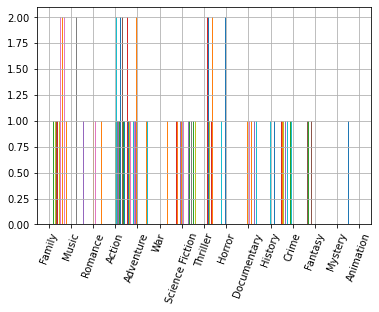

In [211]:
MSIP = vgdf[vgdf['Microsoft'] != 'useless']
MSIP['Genre'].hist(xrot = 70)

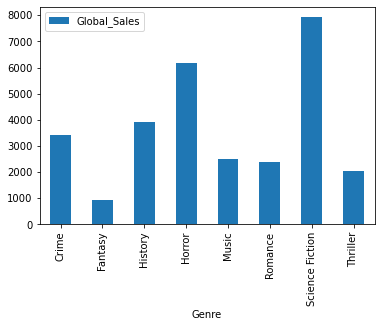

In [215]:
vgdfg.groupby('Genre').sum().plot.bar(y ='Global_Sales')

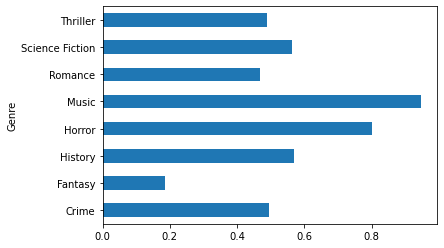

In [216]:
vgdfg.groupby('Genre').Global_Sales.mean().plot.barh()

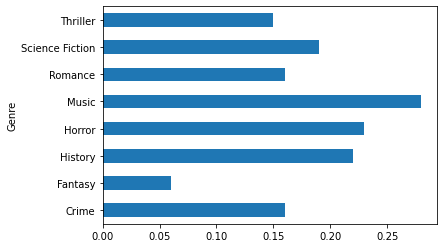

In [217]:
vgdfg.groupby('Genre').Global_Sales.median().plot.barh()

Next going to try and translate the game genres to movie genres and clean the movie genres column so that it makes sense

In [122]:
xyz = merged_df[(merged_df['genres'] != float)]
xyz = xyz.drop(113,axis = 0)
xyz = xyz.drop(254,axis = 0)
xyz = xyz.drop(287,axis = 0)
xyz = xyz.drop(630,axis = 0)
xyz
xyz['genres'] = xyz['genres'].apply(lambda x: [y['name'] for y in x])
xyz['genres']

0                   [Adventure, Science Fiction, Action]
1          [Action, Adventure, Fantasy, Science Fiction]
2                                       [Drama, Romance]
3          [Action, Adventure, Science Fiction, Fantasy]
4                   [Adventure, Action, Science Fiction]
                             ...                        
995                                   [Action, Thriller]
996                                     [Family, Comedy]
997                                      [Drama, Comedy]
998    [War, History, Action, Adventure, Drama, Romance]
999                                     [Drama, Romance]
Name: genres, Length: 996, dtype: object

In [123]:
print([x for x in xyz])

['Rank', 'Title', 'Worldwide_Lifetime_Gross', 'Domestic_Lifetime_Gross', 'Domestic_Percentage', 'Foreign_Lifetime_Gross', 'Foreign_Lifetime_Percentage', 'Year', 'imdb_id', 'adult', 'backdrop_path', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count', 'success', 'status_code', 'status_message']


In [124]:
genredata = list(xyz.values)

In [125]:
imtiredanddontknowwhatimdoing = []
length = len(genredata)
for i in range(0,length):
    templist = genredata[i][13]
    for j in templist:
        a = genredata[i]
        a[13] = j
        imtiredanddontknowwhatimdoing.append(a)
        
        

In [126]:
genredata = pd.DataFrame(data = imtiredanddontknowwhatimdoing, columns = ['Rank', 'Title', 'Worldwide_Lifetime_Gross', 'Domestic_Lifetime_Gross', 'Domestic_Percentage', 'Foreign_Lifetime_Gross', 'Foreign_Lifetime_Percentage', 'Year', 'imdb_id', 'adult', 'backdrop_path', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count', 'success', 'status_code', 'status_message'])
genredata['Worldwide_Lifetime_Gross'] = genredata['Worldwide_Lifetime_Gross'].apply(lambda x: int(x.replace('$','').replace(',',(''))))
genredata['Domestic_Lifetime_Gross'] = genredata['Domestic_Lifetime_Gross'].apply(lambda x: int(x.replace('$','').replace(',',(''))))
genredata['Foreign_Lifetime_Gross'] = genredata['Foreign_Lifetime_Gross'].apply(lambda x: int(x.replace('$','').replace(',',(''))))
genredata['Worldwide_Lifetime_Gross']


0       2797800564
1       2797800564
2       2797800564
3       2790439000
4       2790439000
           ...    
2988     167298192
2989     167298192
2990     167298192
2991     166842739
2992     166842739
Name: Worldwide_Lifetime_Gross, Length: 2993, dtype: int64

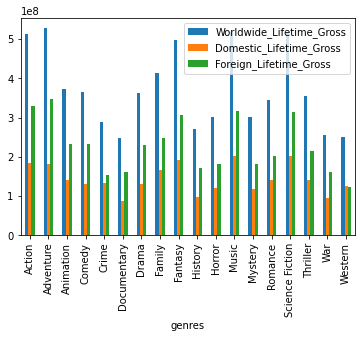

In [127]:
ybc = genredata[['genres','Worldwide_Lifetime_Gross','Domestic_Lifetime_Gross','Foreign_Lifetime_Gross']].groupby('genres').mean()
ybc.plot.bar()

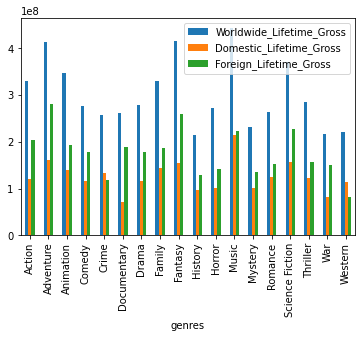

In [128]:
ybc = genredata[['genres','Worldwide_Lifetime_Gross','Domestic_Lifetime_Gross','Foreign_Lifetime_Gross']].groupby('genres').median()
ybc.plot.bar()

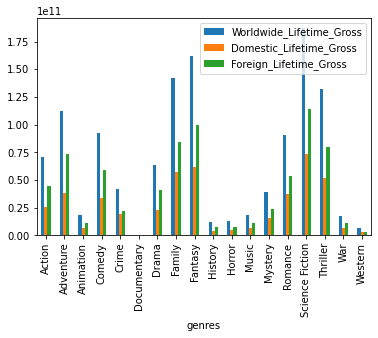

In [129]:
ybc = genredata[['genres','Worldwide_Lifetime_Gross','Domestic_Lifetime_Gross','Foreign_Lifetime_Gross']].groupby('genres').sum()
ybc.plot.bar()

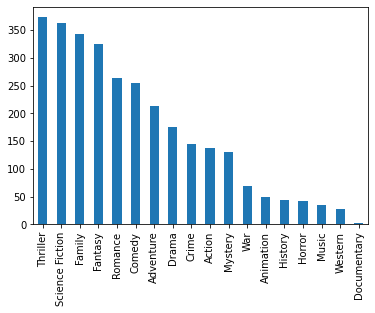

In [130]:
ybc = genredata[['genres','Worldwide_Lifetime_Gross','Domestic_Lifetime_Gross','Foreign_Lifetime_Gross']]
ybc.genres.value_counts().plot.bar()







genres
Action       946.0
Adventure   1451.5
Animation    315.0
Comedy      1648.0
Crime        999.8
Name: vote_average, dtype: float64

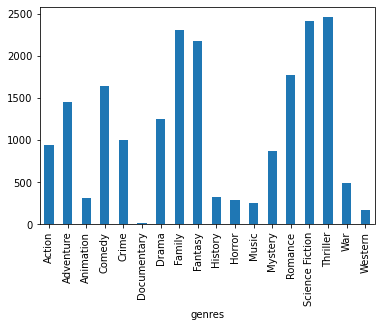

In [131]:
ybc = genredata.groupby('genres').vote_average.sum()
ybc.plot.bar()
ybc.head()

Index(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery',
       'Romance', 'Science Fiction', 'Thriller', 'War', 'Western'],
      dtype='object', name='genres')

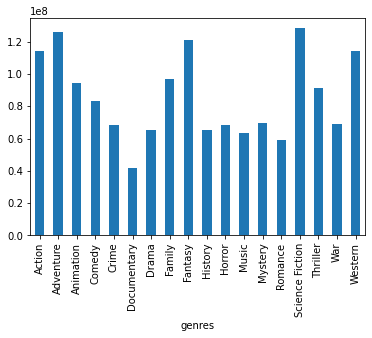

In [149]:
ybc = genredata.groupby('genres').budget.mean()
ybc.plot.bar()
ybc.head()
ybc.keys()

genres
Action      110000000.0
Adventure   140000000.0
Animation   103000000.0
Comedy       76500000.0
Crime        60000000.0
Name: budget, dtype: float64

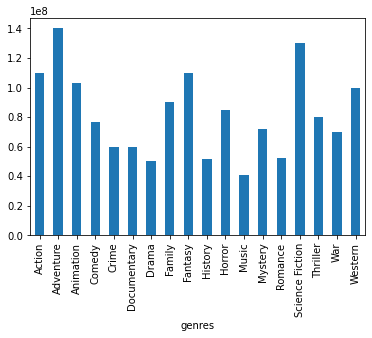

In [144]:
abc = genredata.groupby('genres').budget.median()
abc.plot.bar()
abc.head()

genres
Action      10000000.0
Adventure          0.0
Animation   26500000.0
Comedy             0.0
Crime        6000000.0
Name: budget, dtype: float64

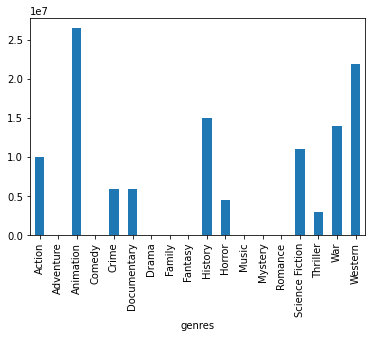

In [145]:
zxc =genredata.groupby('genres').budget.min()
zxc.plot.bar()
zxc.head()

genres
Action      356000000.0
Adventure   270000000.0
Animation   150000000.0
Comedy      230000000.0
Crime       200000000.0
Name: budget, dtype: float64

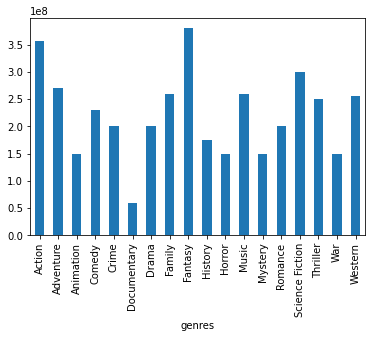

In [146]:
ubc = genredata.groupby('genres').budget.max()
ubc.plot.bar()
ubc.head()

In [154]:
asd = list(zip(ubc,ybc,abc,zxc))

In [155]:
asd = pd.DataFrame(asd, index = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery',
       'Romance', 'Science Fiction', 'Thriller', 'War', 'Western'], columns = ['max','mean','median','min'] )

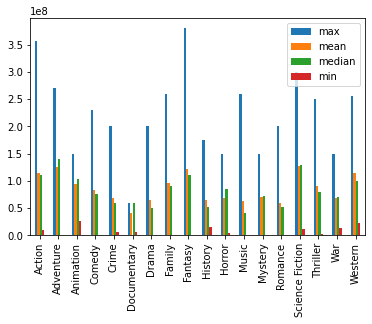

In [156]:
asd.plot.bar()

In [218]:
vgdf.to_csv('Data/vgdata.csv')
vgdfg.to_csv('Data/vgdatagenre.csv')
genredata.to_csv('Data/Genre.csv')
xyz.to_csv('Data/xyz.csv')